In [1]:
import numpy as np
from math import sqrt
from os.path import *
import time
import numba

AU_2_EV = 27.211396

### Coulomb Interaction
Consider two molecules, each with excitation energies $E_1$ and $E_2$ and transition densities $\rho_{eg}(\mathbf{r}_1)$ and $\rho_{eg}(\mathbf{r}_2)$.  
<img src="images/monomers.png" alt="Drawing" style="width: 400px;"/>  
When combined, the supramolecular system have will have new excited states with a splitting $\Delta$  
<img src="images/splitting.png" alt="Drawing" style="width: 500px;"/>  
This splitting depends on their Coulomb coupling,  
<img src="images/eq_coulomb.png" alt="Drawing" style="width: 300px;"/>  
This can be approximated by dividing the density into a grid and summing over each density "cubes"  
<img src="images/eq_coulomb_approx.png" alt="Drawing" style="width: 150px;"/>
<img src="images/cube_sum.png" alt="Drawing" style="width: 400px;"/>


In [20]:
import Cube
data_1 = Cube.CubeData(join('CV_data', 'transdens_1_low.cub'))
data_2 = Cube.CubeData(join('CV_data', 'transdens_2_low.cub'))
dV_12 = data_1.dV * data_2.dV
data_1_L = Cube.CubeData(join('CV_data', 'transdens_1_extra_low.cub'))
data_2_L = Cube.CubeData(join('CV_data', 'transdens_2_extra_low.cub'))
dV_12_L = data_1_L.dV * data_2_L.dV

print("Number of points in regular cubes: ", data_1.coords.shape, data_2.coords.shape)
print("                                   ", data_1.cube_data.shape, data_2.cube_data.shape)

print("Number of points in reduced cubes: ", data_1_L.coords.shape, data_2_L.coords.shape)
print("                                   ", data_1_L.cube_data.shape, data_2_L.cube_data.shape)

point_ratio = data_1.n_points * data_2.n_points/(data_1_L.n_points * data_2_L.n_points)
print("Point ratio: ", point_ratio)

#   will store all of our benchmarks
global_timers = {}

Reading cube file
Formatting
Done
Reading cube file
Formatting
Done
Reading cube file
Formatting
Done
Reading cube file
Formatting
Done
Number of points in regular cubes:  (61617, 3) (66654, 3)
                                    (61617,) (66654,)
Number of points in reduced cubes:  (2975, 3) (5220, 3)
                                    (2975,) (5220,)
Point ratio:  264.46566328600403


In [21]:
def calc_coulomb_pure_python(pts_1, rho_1, pts_2, rho_2, dV):
    from math import sqrt   #   normally, this is imported beforehand, but we need to fix fomr Jupyter multiprocessing bugs (discussed later)
    total = 0.0
    count = 0
    n_pts_1 = len(pts_1)
    n_pts_2 = len(pts_2)
    n_pts_12 = n_pts_1*n_pts_2
    print_num = n_pts_12//5
    for i in range(n_pts_1):
        for j in range(n_pts_2):
            if count % print_num == 0:
                print(f"    Coulomb Integral {(count / n_pts_12*100):.1f} %")

            x1, y1, z1 = pts_1[i]
            x2, y2, z2 = pts_2[j]
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            r = sqrt(dx**2 + dy**2 + dz**2)
            total += rho_1[i]*rho_2[j]/r
            count += 1
    return total*dV

start = time.time()
total = calc_coulomb_pure_python(data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio
global_timers['pure_python'] = (total, total_time)
print(f'pure_python: {total_time:.2f} s ({total*AU_2_EV} eV)')

    Coulomb Integral 0.0 %
    Coulomb Integral 20.0 %
    Coulomb Integral 40.0 %
    Coulomb Integral 60.0 %
    Coulomb Integral 80.0 %
pure_python: 5362.92 s (0.23374090007118797 eV)


#### Numpy
Numpy gives us a way to manipulate multiple data points, stored in arrays, at the same time.
- Think of numpy arrays as mathematical vectors and matricies

In [37]:
import numpy as np

a = np.array([1, 2, 3, 4, 5])
b = np.array([2, 3, 4, 5, 6])
c = np.array([[1, 2], [3, 4]])
d = np.array([[2, 0], [0, 3]])

print(f"{ a + 2 = }")
print(f"{ np.sum(a) = }")
print(f"{ a * b = }")
print(f"{ c @ d = }")

 a + 2 = array([3, 4, 5, 6, 7])
 np.sum(a) = 15
 a * b = array([ 2,  6, 12, 20, 30])
 c @ d = array([[ 2,  6],
       [ 6, 12]])


In [4]:
# def calc_coulomb_pure_python(xyz_1: np.ndarray, dens_1: np.ndarray, xyz_2: np.ndarray, dens_2: np.ndarray):
def calc_coulomb_numpy(pts_1, rho_1, pts_2, rho_2, dV):
    total = 0.0
    count = 0
    n_pts_1 = len(pts_1)
    print_num = n_pts_1//5
    for i in range(n_pts_1):
        if count % print_num == 0:
            print(f"    Coulomb Integral {(count / n_pts_1*100):.1f} %")

        dr = pts_1[i] - pts_2
        r = np.linalg.norm(dr, axis=1)
        total += rho_1[i]*np.sum(rho_2/r)
        count += 1

    return total*dV

start = time.time()
total = calc_coulomb_numpy(data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
# total = calc_coulomb_numpy(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)*point_ratio
global_timers['numpy_L'] = (total, total_time)
print(f'numpy_L: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

    Coulomb Integral 0.0 %
    Coulomb Integral 20.0 %
    Coulomb Integral 40.0 %
    Coulomb Integral 60.0 %
    Coulomb Integral 80.0 %
numpy_L: 78.55 s (0.2337409000711968 a.u.)


In [7]:
@numba.jit(nopython=True)
def calc_coulomb_numba(pts_1, rho_1, pts_2, rho_2, dV):
    total = 0.0
    n_pts_1 = len(pts_1)
    n_pts_2 = len(pts_2)
    for i in numba.prange(n_pts_1):
        for j in range(n_pts_2):

            x1, y1, z1 = pts_1[i]
            x2, y2, z2 = pts_2[j]
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            r = sqrt(dx**2 + dy**2 + dz**2)
            total += rho_1[i]*rho_2[j]/r
            
    return total*dV

start = time.time()
total = calc_coulomb_numba(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numba'] = (total, total_time)
print(f'numba: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

numba: 14.96 s (0.2422872334903655 a.u.)


In [9]:
@numba.jit(nopython=True, parallel=True)
def calc_coulomb_numba_parallel(pts_1, rho_1, pts_2, rho_2, dV):
    total = 0.0
    n_pts_1 = len(pts_1)
    n_pts_2 = len(pts_2)
    for i in numba.prange(n_pts_1):
        for j in range(n_pts_2):

            x1, y1, z1 = pts_1[i]
            x2, y2, z2 = pts_2[j]
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            r = sqrt(dx**2 + dy**2 + dz**2)
            total += rho_1[i]*rho_2[j]/r
            
    return total*dV

start = time.time()
numba.set_num_threads(4)
total = calc_coulomb_numba_parallel(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numba_parallel'] = (total, total_time)
print(f'numba_parallel: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

numba_parallel: 4.55 s (0.24228723350222542 a.u.)


In [12]:
@numba.jit(parallel=True, nopython=True)
def calc_coulomb_numba_parallel_numpy(pts_1, rho_1, pts_2, rho_2, dV):

    n_pts_1 = len(pts_1)
    total = 0.0
    count = 0.0
    n_threads = numba.get_num_threads()
    for i in numba.prange(n_pts_1):

        dr = pts_2 - pts_1[i]
        dr2 = dr*dr
        r = np.sqrt(dr2[:, 0] + dr2[:, 1] + dr2[:, 2])
        total += rho_1[i]*np.sum(rho_2/r)
        count += 1

    return total*dV

start = time.time()
numba.set_num_threads(4)
total = calc_coulomb_numba_parallel_numpy(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numba_parallel_numpy'] = (total, total_time)
print(f'numba_parallel_numpy: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

numba_parallel_numpy: 10.03 s (0.2422872335002303 a.u.)


In [11]:
@numba.jit(nopython=True)
def calc_coulomb_numba_numpy(pts_1, rho_1, pts_2, rho_2, dV):
    n_pts_1 = len(pts_1)
    total = 0.0
    for i in numba.prange(n_pts_1):
        dr = pts_2 - pts_1[i]
        dr2 = dr*dr
        r = np.sqrt(dr2[:, 0] + dr2[:, 1] + dr2[:, 2])
        total += rho_1[i]*np.sum(rho_2/r)

    return total*dV

start = time.time()
total = calc_coulomb_numba_numpy(data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numba_numpy'] = (total, total_time)
print(f'numba_numpy: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

KeyboardInterrupt: 

In [13]:
import threading

thread_totals = np.array([])
# @numba.jit(nopython=True)
def _coulomb_by_indix(indicies, pts_1, rho_1, pts_2, rho_2, dV, thread_ID):

    total = 0.0
    count = 0
    n_pts_1 = len(indicies)
    n_pts_2 = len(pts_2)
    n_pts_12 = n_pts_1*n_pts_2
    print_num = n_pts_12//5
    for i in indicies: # EDIT: loop over specified indicies only
        for j in range(n_pts_2):
            if count % print_num == 0:
                #   Also print thread ID
                print(f"    Coulomb Integral {thread_ID} {(count / n_pts_12*100):.1f} %")

            x1, y1, z1 = pts_1[i]
            x2, y2, z2 = pts_2[j]
            dx = x1 - x2
            dy = y1 - y2
            dz = z1 - z2
            r = sqrt(dx**2 + dy**2 + dz**2)
            total += rho_1[i]*rho_2[j]/r
            count += 1

    # thread_totals[thread_ID] = total*dV

def calc_coulomb_thread(n_threads, pts_1, rho_1, pts_2, rho_2, dV):
    global thread_totals
    all_threads = []
    thread_totals = np.zeros(n_threads)
    for n in range(n_threads):
        #   these will be the indicies used by the inner Coulomb loop
        indicies = np.arange(n, len(pts_1), n_threads)
        print(f"Thread {n} using indicies ", *indicies[0:4], "...")
        
        thread = threading.Thread(target=_coulomb_by_indix, args=(indicies, pts_1, rho_1, pts_2, rho_2, dV, n))
        all_threads.append(thread)
        thread.start()

    for thread in all_threads:
        thread.join()

    return np.sum(thread_totals)

start = time.time()
total = calc_coulomb_thread(4, data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
# total = calc_coulomb_thread(4, data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)*point_ratio
global_timers['threaded'] = (total, total_time)
print(f'threaded: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

Thread 0 using indicies  0 4 8 12 ...
    Coulomb Integral 0 0.0 %
Thread 1 using indicies  1 5 9 13 ...
    Coulomb Integral 1 0.0 %
Thread 2 using indicies  2 6 10 14 ...
    Coulomb Integral 2 0.0 %
Thread 3 using indicies  3 7 11 15 ...
    Coulomb Integral 3 0.0 %
    Coulomb Integral 1 20.0 %
    Coulomb Integral 0 20.0 %
    Coulomb Integral 3 20.0 %
    Coulomb Integral 2 20.0 %
    Coulomb Integral 1 40.0 %
    Coulomb Integral 3 40.0 %
    Coulomb Integral 0 40.0 %
    Coulomb Integral 2 40.0 %
    Coulomb Integral 1 60.0 %
    Coulomb Integral 3 60.0 %
    Coulomb Integral 0 60.0 %
    Coulomb Integral 2 60.0 %
    Coulomb Integral 1 80.0 %
    Coulomb Integral 3 80.0 %
    Coulomb Integral 0 80.0 %
    Coulomb Integral 2 80.0 %
threaded: 15281.22 s (0.0 a.u.)


In [9]:
import multiprocess as mp # use with Jupyter Notebooks
#import multiprocess as mp # use with traditional python files

def calc_coulomb_MP(n_proc, pts_1, rho_1, pts_2, rho_2, dV):
    #   outer loop will be split by each process
    pts_1_split = np.array_split(pts_1, n_proc)
    rho_1_split = np.array_split(rho_1, n_proc)

    #   inner loop will remain the same, so we simply copy the data
    pts_2_copies = [pts_2]*n_proc
    rho_2_copies = [rho_2]*n_proc

    #   a copy also needs to be supplied to each process
    dV_list = [dV]*n_proc

    with mp.Pool(n_proc) as pool:
        func_params = zip(pts_1_split, rho_1_split, pts_2_copies, rho_2_copies, dV_list)
        results = pool.starmap(calc_coulomb_pure_python, func_params)

    return np.sum(results)

# calc_coulomb_pure_python(data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)

start = time.time()
total = calc_coulomb_MP(4, data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio
global_timers['multiprocessing'] = (total, total_time)
print(f'multiprocessing: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

multiprocessing: 4139.28 s (0.23374090007120177 a.u.)


In [85]:
a = np.arange(10)
np.array_split(a, 3)

[array([0, 1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])]

In [93]:
def calc_coulomb_MP_numba(n_proc, pts_1, rho_1, pts_2, rho_2, dV):
    #   outer loop will be split by each process
    pts_1_split = np.array_split(pts_1, n_proc)
    rho_1_split = np.array_split(rho_1, n_proc)

    #   inner loop will remain the same, so we simply copy the data
    pts_2_copies = [pts_2]*n_proc
    rho_2_copies = [rho_2]*n_proc

    #   a copy also needs to be supplied to each process
    dV_list = [dV]*n_proc

    with mp.Pool(n_proc) as pool:
        func_params = zip(pts_1_split, rho_1_split, pts_2_copies, rho_2_copies, dV_list)
        results = pool.starmap(calc_coulomb_numba, func_params)

    return np.sum(results)

n_keep = 1
start = time.time()
total = calc_coulomb_MP_numba(4, data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio
global_timers['multiprocessing_numba'] = (total, total_time)
print(f'multiprocessing_numba: {total_time:.2f} s ({total} a.u.)')

multiprocessing_numba: 68.91 s (0.008589816563295825 a.u.)


In [15]:
for name, val in global_timers.items():
    print(f'{name:25s} {val[1]:10.1f}')

pure_python                  14535.4
numpy_L                         78.5
numba                           15.0
numba_parallel                   4.5
numba_parallel_numpy            10.0
threaded                        46.5


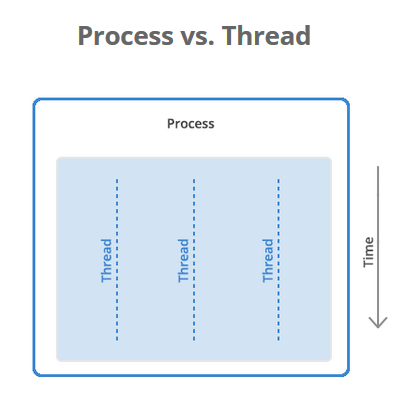

In [14]:
import threading

thread_totals = np.array([])
# @numba.jit(nopython=True)
def _coulomb_by_indix_2(indicies, pts_1, rho_1, pts_2, rho_2, dV, thread_ID):

    total = 0.0
    count = 0
    n_pts_1 = len(indicies)
    print_num = n_pts_1//5
    for i in indicies: # EDIT: loop over specified indicies only
        if count % print_num == 0:
            #   Also print thread ID
            print(f"    Coulomb Integral      {thread_ID} {(count / n_pts_1*100):.1f} %")

            
        dr = pts_2 - pts_1[i]
        dr2 = dr*dr
        r = np.sqrt(dr2[:, 0] + dr2[:, 1] + dr2[:, 2])
        total += rho_1[i]*np.sum(rho_2/r)
        count += 1


    thread_totals[thread_ID] = total*dV

def calc_coulomb_thread_2(n_threads, pts_1, rho_1, pts_2, rho_2, dV):
    global thread_totals
    all_threads = []
    thread_totals = np.zeros(n_threads)
    for n in range(n_threads):
        #   these will be the indicies used by the inner Coulomb loop
        indicies = np.arange(n, len(pts_1), n_threads)
        print(f"Thread {n} using indicies ", *indicies[0:4], "...")
        
        thread = threading.Thread(target=_coulomb_by_indix_2, args=(indicies, pts_1, rho_1, pts_2, rho_2, dV, n))
        all_threads.append(thread)
        thread.start()

    for thread in all_threads:
        thread.join()

    return np.sum(thread_totals)

start = time.time()
# total = calc_coulomb_thread_2(4, data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total = calc_coulomb_thread_2(4, data_1.coords, data_1.cube_data, data_2.coords, data_2.cube_data, dV_12)
total_time = (time.time() - start)
global_timers['numpy_threaded'] = (total, total_time)
print(f'numpy_threaded: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

Thread 0 using indicies  0 4 8 12 ...
    Coulomb Integral      0 0.0 %
Thread 1 using indicies  1 5 9 13 ...
    Coulomb Integral      1 0.0 %
Thread 2 using indicies  2 6 10 14 ...
    Coulomb Integral      2 0.0 %
Thread 3 using indicies  3 7 11 15 ...
    Coulomb Integral      3 0.0 %
    Coulomb Integral      0 20.0 %
    Coulomb Integral      1 20.0 %
    Coulomb Integral      2 20.0 %
    Coulomb Integral      3 20.0 %
    Coulomb Integral      1 40.0 %
    Coulomb Integral      0 40.0 %
    Coulomb Integral      2 40.0 %
    Coulomb Integral      3 40.0 %
    Coulomb Integral      1 60.0 %
    Coulomb Integral      0 60.0 %
    Coulomb Integral      2 60.0 %
    Coulomb Integral      3 60.0 %
    Coulomb Integral      1 80.0 %
    Coulomb Integral      3 80.0 %
    Coulomb Integral      0 80.0 %
    Coulomb Integral      2 80.0 %
    Coulomb Integral      1 100.0 %
    Coulomb Integral      3 100.0 %
    Coulomb Integral      2 100.0 %
threaded: 46.47 s (0.2422872335002314 a.u.

In [ ]:
# def calc_coulomb_pure_python(xyz_1: np.ndarray, dens_1: np.ndarray, xyz_2: np.ndarray, dens_2: np.ndarray):
def calc_coulomb_pure_numpy_mix(pts_1, rho_1, pts_2, rho_2, dV):
    print("Pure Python Coulomb Integral")

    total = 0.0
    count = 0
    n_pts_1 = len(pts_1)
    n_pts_2 = len(pts_2)
    n_pts_12 = n_pts_1*n_pts_2
    print_num = n_pts_12//5
    for i in range(n_pts_1):
        for j in range(n_pts_2):
            if count % print_num == 0:
                print(f"    Coulomb Integral {(count / n_pts_12*100):.1f} %")

            dr = pts_1[i] - pts_2[j]
            r = np.linalg.norm(dr)
            total += rho_1[i]*rho_2[j]/r
            count += 1

    return total*dV

start = time.time()
total = calc_coulomb_pure_numpy_mix(data_1_L.coords, data_1_L.cube_data, data_2_L.coords, data_2_L.cube_data, dV_12_L)
total_time = (time.time() - start)*point_ratio
global_timers['pure_numpy_mix'] = (total, total_time)
print(f'pure_numpy_mix: {total_time:.2f} s ({total*AU_2_EV} a.u.)')

Pure Python Coulomb Integral
    Coulomb Integral 0.0 %


KeyboardInterrupt: 